# Optimization and Algorithms Project - Task 11

## Group Members
*David Marafuz Gaspar* | 106541  
*Pedro Gaspar Mónico* | 106626  
*Francisco Palma* | 105949  
*Pedro Salazar Leite* | 106812  

In [5]:
import numpy as np
import matplotlib.pylab as plt

In [6]:

# Helper function for Calculate the Gradient
def grad(C, circle_data):
    C = C.reshape(-1)  # ensures shape (2,)
    grad_matrix = np.zeros((3, circle_data.shape[1]))
    for p in range(circle_data.shape[1]):
        diff = C - circle_data[:, p]
        norm_diff = np.linalg.norm(diff)
        grad_matrix[0, p] = diff[0] / norm_diff
        grad_matrix[1, p] = diff[1] / norm_diff
        grad_matrix[2, p] = -1
    return grad_matrix

# Helper function for Calculate the Total Gradient
def total_grad(grad_matrix, f_p):
    return 2.0 * grad_matrix @ f_p  # shape (3,1)

# Helper function for Calculate the Value of the Function
def f_value(C, R, circle_data):
    f_p = np.zeros((circle_data.shape[1], 1))
    for p in range(circle_data.shape[1]):
        f_p[p, 0] = np.linalg.norm(C - circle_data[:, p]) - R
    return f_p



In [7]:
#  Load data 
circle_data = np.load("Data/circle_data_2.npy")

[[-0.44638224]
 [ 1.50461084]]
[0.59304295]


/tmp/ipykernel_45747/4188216324.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R = float(R_ls)
/tmp/ipykernel_45747/4188216324.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R_trial = float(x_pred[2])
/tmp/ipykernel_45747/4188216324.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_x_k = float(f_p.T @ f_p)
/tmp/ipykernel_45747/4188216324.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in fut

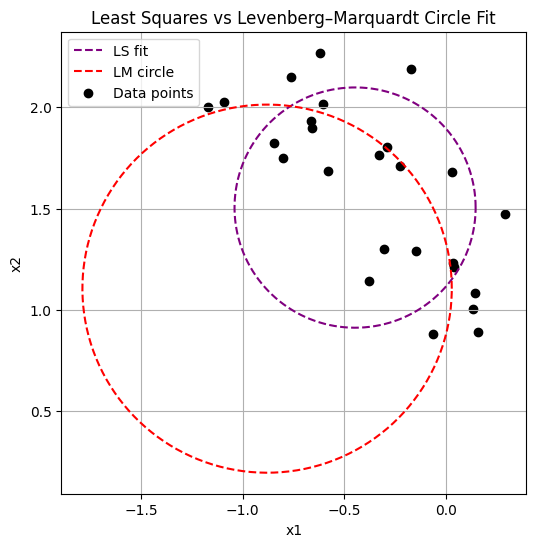

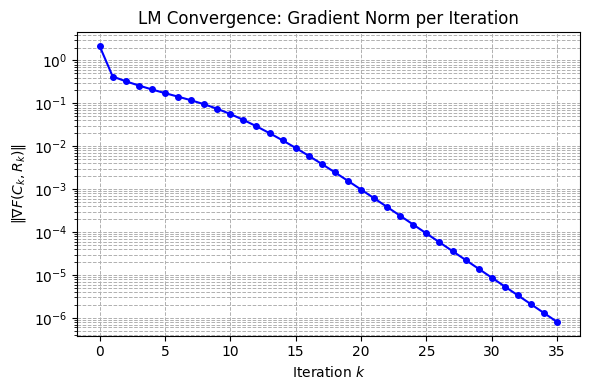

In [8]:
#  LS solution 
A = np.zeros((circle_data.shape[1], 3))
for i in range(circle_data.shape[1]):
    A[i, 0] = 1
    A[i, 1] = -2 * circle_data[0, i]
    A[i, 2] = -2 * circle_data[1, i]

b = np.zeros((circle_data.shape[1], 1))
for i in range(circle_data.shape[1]):
    b[i, 0] = -(np.linalg.norm(circle_data[:, i]) ** 2)

x_atomic, *_ = np.linalg.lstsq(A, b, rcond=None)
y_optimal = x_atomic[0]
c_ls = x_atomic[1:]
print(c_ls)
R_ls = np.sqrt(np.linalg.norm(c_ls) ** 2 - y_optimal)
print(R_ls)

#  LM refinement 
eps = 1e-6
lamba = 1.0
C = c_ls.reshape(-1)
R = float(R_ls)

gradient_norms = []  # store gradient norms
iterations = 0

while True:
    f_p = f_value(C, R, circle_data)
    grad_f = grad(C, circle_data)
    total_grad_f = total_grad(grad_f, f_p)

    grad_norm = np.linalg.norm(total_grad_f)
    gradient_norms.append(grad_norm)

    if grad_norm < eps:
        break

    grad_f_T = grad_f.T
    lamba_eye = np.sqrt(lamba) * np.eye(3)
    A = np.vstack((grad_f_T, lamba_eye))
    x_k = np.vstack((C.reshape(2, 1), [[R]]))
    b = np.vstack((grad_f_T @ x_k - f_p, np.sqrt(lamba) * x_k))

    x_pred, *_ = np.linalg.lstsq(A, b, rcond=None)
    C_trial = x_pred[:2].ravel()
    R_trial = float(x_pred[2])

    f_x_k = float(f_p.T @ f_p)
    f_p1 = f_value(C_trial, R_trial, circle_data)
    f_x_k1 = float(f_p1.T @ f_p1)

    if f_x_k1 < f_x_k:
        C, R = C_trial, R_trial
        lamba *= 0.7
    else:
        lamba *= 2

    iterations += 1

#  Plot circles 
theta = np.linspace(0, 2 * np.pi, 300)

circle_x_ls = c_ls[0] + R_ls * np.cos(theta)
circle_y_ls = c_ls[1] + R_ls * np.sin(theta)

circle_x_lm = C[0] + R * np.cos(theta)
circle_y_lm = C[1] + R * np.sin(theta)

plt.figure(figsize=(6, 6))
plt.plot(circle_x_ls, circle_y_ls, label="LS fit", color="purple", linestyle="--")
plt.plot(circle_x_lm, circle_y_lm, label="LM circle", color="red", linestyle="--")
plt.scatter(circle_data[0, :], circle_data[1, :], color="black", label="Data points")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.title("Least Squares vs Levenberg–Marquardt Circle Fit")
plt.xlabel("x1")
plt.ylabel("x2")

#  Plot convergence curve 
plt.figure(figsize=(6, 4))
plt.semilogy(gradient_norms, marker="o", color="blue", linewidth=1.5, markersize=4)
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.title("LM Convergence: Gradient Norm per Iteration")
plt.xlabel("Iteration $k$")
plt.ylabel(r"$\|\nabla F(C_k,R_k)\|$")
plt.tight_layout()
